# analyzing data from scrapes...

In [1]:
import json
import pandas as pd
import os
import re
import itertools
import nltk
import sklearn
from nltk.stem.porter import PorterStemmer
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem import SnowballStemmer 
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

In [2]:
sklearn.show_versions()


System:
    python: 3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 20:33:18)  [Clang 11.1.0 ]
executable: /Users/harry/miniconda3/envs/py39/bin/python
   machine: macOS-13.0.1-x86_64-i386-64bit

Python dependencies:
      sklearn: 1.1.2
          pip: 22.2.2
   setuptools: 65.2.0
        numpy: 1.23.2
        scipy: 1.9.0
       Cython: 0.29.24
       pandas: 1.3.3
   matplotlib: 3.5.1
       joblib: 1.1.0
threadpoolctl: 3.1.0

Built with OpenMP: True

threadpoolctl info:
       user_api: blas
   internal_api: openblas
         prefix: libopenblas
       filepath: /Users/harry/miniconda3/envs/py39/lib/libopenblasp-r0.3.21.dylib
        version: 0.3.21
threading_layer: openmp
   architecture: Haswell
    num_threads: 16

       user_api: openmp
   internal_api: openmp
         prefix: libomp
       filepath: /Users/harry/miniconda3/envs/py39/lib/libomp.dylib
        version: None
    num_threads: 16


In [3]:
print(nltk.__version__)

3.6.5


In [4]:
print(pd.__version__)

1.3.3


# ok. build up list of all files. for each, get ID, title, and fileType set

In [5]:
def read_file(fname):
    with open(fname,'r') as jfile:
        data = json.load(jfile)
    return data

# this next routine really isn't used...
def get_summary(fname):
    data = read_file(fname)
    res={}
    res['metadataCollectionId']=data['metadataCollectionId']
    res['titleEnglish']=data['titleEnglish']
    res['fileTypeSet']=data['fileTypeSet']
    return res

def get_files(path):
    files=[]
    for file in os.listdir(path):
        file =path+"/"+file
        if file.endswith(".json"):
            files.append(file) 
    return files

In [6]:
summaries = [read_file(fname) for fname in get_files("../10_rows")]

In [7]:
len(summaries)

294

In [8]:
## Question - how many of these summaries have more than one file type?

In [9]:
multi_files = [f for f in summaries if len(f['fileTypeSet']) > 1]

In [10]:
len(multi_files)

146

In [11]:
three_fer = [f for f in summaries if len(f['fileTypeSet'])>2]
len(three_fer)

41

In [12]:
four_fer = [f for f in summaries if len(f['fileTypeSet'])>3]
len(four_fer)

7

In [13]:
type_counts=[len(f['fileTypeSet']) for f in summaries]

ok. how to get them to spread out a bit and to center on value?

In [14]:
tcseries = pd.Series(type_counts)

In [15]:
bar  = pd.DataFrame(tcseries.value_counts())
bar

,0
1,148
2,105
3,34
4,6
5,1


<AxesSubplot:>

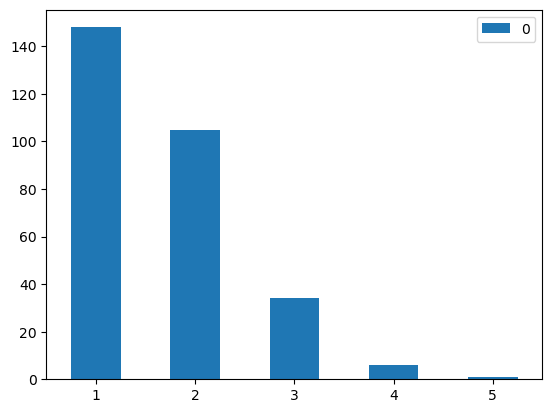

In [16]:
bar.plot(kind="bar",rot=0)

ok. so 146/294, slightly less than 50% have multiple file types

#### look at type distribution - how many have pdf,json,csv, html,png, etc.

In [17]:
type_sum={}
for s in summaries:
    ftypes = s['fileTypeSet']
    for ftype in ftypes:
        atype = ftype['fileType']
        if atype not in type_sum:
            type_sum[atype]=0
        type_sum[atype]=type_sum[atype]+1

In [18]:
type_sum

{'html': 78,
 'xlsx': 28,
 'pdf': 47,
 'csv': 132,
 'png': 114,
 'twbx': 5,
 'json': 74,
 'docx': 1,
 'zip': 3,
 'tsv': 1,
 'xls': 2,
 'js': 1,
 'ods': 1,
 'rds': 1,
 'jpg': 1}

In [19]:
counts = list(type_sum.values())
counts

[78, 28, 47, 132, 114, 5, 74, 1, 3, 1, 2, 1, 1, 1, 1]

In [20]:
sum(counts)

489

## ok. write a routine to filter summaries (and files) by type), then dig into types

In [21]:
def get_summaries_by_type(summaries,target):
    res = []
    for s in summaries:
        match = False
        fts  = s['fileTypeSet']
        for ft in fts:
            atype = ft['fileType']
            if atype == target:
                match = True
        if match == True:
            res.append(s)
    return res

In [22]:
jsons = get_summaries_by_type(summaries,'json')
len(jsons)

74

In [23]:
htmls=get_summaries_by_type(summaries,'html')
len(htmls)

78

In [24]:
xlsx = get_summaries_by_type(summaries,'xlsx')

In [25]:
len(xlsx)

28

#### try some easy ones - pdf and png

In [26]:
pdfs = get_summaries_by_type(summaries,'pdf')

In [27]:
len(pdfs)

47

In [28]:
pdfs[0]

{'metadataCollectionId': 683,
 'titleEnglish': 'Archived Data from New Jersey Department of Health: "New Jersey Department of Health COVID-19 Confirmed Case Summary "',
 'fileTypeSet': [{'fileType': 'pdf', 'fileCount': 60}]}

In [29]:
pdfs[1]['fileTypeSet']

[{'fileType': 'pdf', 'fileCount': 2158},
 {'fileType': 'csv', 'fileCount': 269},
 {'fileType': 'png', 'fileCount': 304}]

In [30]:
pdfs[1].keys()

dict_keys(['metadataCollectionId', 'titleEnglish', 'fileTypeSet', 'fileSet'])

In [31]:
len(pdfs[1]['fileSet'])

269

In [32]:
pdfs1_fsnames = [f['filename'] for f in pdfs[1]['fileSet']]


In [33]:
pdfs[5]

{'metadataCollectionId': 861,
 'titleEnglish': 'Archived Data from Oklahoma State Department of Health: "Oklahoma Response to Coronavirus Disease 2019 (COVID-19)"',
 'fileTypeSet': [{'fileType': 'pdf', 'fileCount': 294},
  {'fileType': 'html', 'fileCount': 165}]}

In [34]:
pngs = get_summaries_by_type(summaries,'png')

In [35]:
pngs[0].keys()

dict_keys(['metadataCollectionId', 'titleEnglish', 'fileTypeSet', 'fileSet'])

In [36]:
pngs[0]['fileTypeSet']

[{'fileType': 'pdf', 'fileCount': 2158},
 {'fileType': 'csv', 'fileCount': 269},
 {'fileType': 'png', 'fileCount': 304}]

In [37]:
len(pngs[0]['fileSet'])

269

In [38]:
pngs[0]['fileSet'][93]

{'filename': 'county_vaccine_2021-12-08_162510.csv',
 'data': [{'sheetData': [['County', 'Date', 'Vaccine', 'Administrations'],
    [None, '12/14/2020', 'Pfizer', '1'],
    [None, '12/15/2020', 'Pfizer', '4'],
    [None, '12/15/2020', 'Unspecified', '1'],
    [None, '12/16/2020', 'Pfizer', '84'],
    [None, '12/17/2020', 'Pfizer', '100'],
    [None, '12/18/2020', 'Pfizer', '296'],
    [None, '12/18/2020', 'Unspecified', '2'],
    [None, '12/19/2020', 'Pfizer', '125'],
    [None, '12/19/2020', 'Unspecified', '1']]}]}

#### ok. look at twbx and zip

In [39]:
twbx = get_summaries_by_type(summaries,'twbx')

In [40]:
len(twbx)

5

all also have csv

In [41]:
jsons = get_summaries_by_type(summaries,'json')

In [42]:
len(jsons[1]['fileSet'])

6

In [43]:
js1fs=jsons[1]['fileSet']

In [44]:
js1js= [f  for f in js1fs if f['filename'].endswith('json')]

In [45]:
js1js

[]

all also have csv!

# Ok,new routine to get any who have one of several types

In [46]:
def get_entries_by_types(entries,targets):
    res = []
    for e in entries:
        match = False
        fts  = e['fileTypeSet']
        for ft in fts:
            atype = ft['fileType']
            if atype in targets:
                match = True
        if match == True:
            res.append(e)
    return res

In [47]:
spreadsheets = get_entries_by_types(summaries,['csv','xlsx','tsv','xlsx','json','ods'])

In [48]:
len(spreadsheets)

204

In [49]:
type_sum

{'html': 78,
 'xlsx': 28,
 'pdf': 47,
 'csv': 132,
 'png': 114,
 'twbx': 5,
 'json': 74,
 'docx': 1,
 'zip': 3,
 'tsv': 1,
 'xls': 2,
 'js': 1,
 'ods': 1,
 'rds': 1,
 'jpg': 1}

In [50]:
type_sum['xlsx']+type_sum['csv']+type_sum['tsv']+type_sum['xls']

163

# Starting to look inside the spreadsheets

In [51]:
s0=spreadsheets[0]

In [52]:
s0.keys()

dict_keys(['metadataCollectionId', 'titleEnglish', 'fileTypeSet', 'fileSet'])

In [53]:
s0['metadataCollectionId']

729

In [54]:
s0fs0=s0['fileSet'][0]

In [55]:
s0fs0

{'filename': 'Downloadable_Demographic_2022-02-01_042303.xlsx',
 'data': [{'sheetName': 'Cases', 'sheetData': [['County']]},
  {'sheetName': 'Hospitalizations-State', 'sheetData': [['County']]},
  {'sheetName': 'Hospitalizations-County', 'sheetData': [['County']]},
  {'sheetName': 'Testing', 'sheetData': [['County']]},
  {'sheetName': 'Data Dictionary', 'sheetData': [['Variable']]}]}

In [56]:
s0['fileSet'][1]

{'filename': 'EpiCurve_Count_Cases_Hospitalizations_Deaths_2022-07-07_042304.xlsx',
 'data': [{'sheetName': 'Cases',
   'sheetData': [['Earliest Specimen Collection Date']]},
  {'sheetName': 'Hospitalizations',
   'sheetData': [['Hospital Admission Date']]},
  {'sheetName': 'Deaths',
   'sheetData': [['Earliest Specimen Collection Date']]},
  {'sheetName': 'Data Dictionary', 'sheetData': [['Variable Name']]}]}

In [57]:
s0['fileSet'][2]

{'filename': 'Downloadable_RaceEthnicity_2022-05-26_042302.xlsx',
 'data': [{'sheetName': 'Cases', 'sheetData': [['Statewide']]},
  {'sheetName': 'Hospitalizations', 'sheetData': [['Statewide']]},
  {'sheetName': 'Testing', 'sheetData': [['Statewide']]},
  {'sheetName': 'Data Dictionary', 'sheetData': [['Variable Name']]}]}

In [58]:
s0['fileSet'][3]

{'filename': 'Downloadable_RaceEthnicity_2022-03-03_042303.xlsx',
 'data': [{'sheetName': 'Cases', 'sheetData': [['Statewide']]},
  {'sheetName': 'Hospitalizations', 'sheetData': [['Statewide']]},
  {'sheetName': 'Testing', 'sheetData': [['Statewide']]},
  {'sheetName': 'Data Dictionary', 'sheetData': [['Variable Name']]}]}

In [59]:
s0['fileSet'][4]

{'filename': 'Downloadable_Demographic_2022-06-09_042302.xlsx',
 'data': [{'sheetName': 'Cases', 'sheetData': [['County']]},
  {'sheetName': 'Hospitalizations-State', 'sheetData': [['County']]},
  {'sheetName': 'Hospitalizations-County', 'sheetData': [['County']]},
  {'sheetName': 'Testing', 'sheetData': [['County']]},
  {'sheetName': 'Data Dictionary', 'sheetData': [['Variable Name']]}]}

In [60]:
s0['fileSet'][5]

{'filename': 'EpiCurve_Count_Cases_Hospitalizations_Deaths_2022-02-19_042303.xlsx',
 'data': [{'sheetName': 'Cases',
   'sheetData': [['Earliest Specimen Collection Date']]},
  {'sheetName': 'Hospitalizations',
   'sheetData': [['Hospital Admission Date']]},
  {'sheetName': 'Deaths',
   'sheetData': [['Earliest Specimen Collection Date']]},
  {'sheetName': 'Data Dictionary', 'sheetData': [['VariableName']]}]}

In [61]:
s0['fileSet'][6]

{'filename': 'WA_COVID19_Cases_Hospitalizations_Deaths_2021-03-30_122302.xlsx',
 'data': [{'sheetName': 'Cases', 'sheetData': [['County']]},
  {'sheetName': 'Hospitalizations', 'sheetData': [['County']]},
  {'sheetName': 'Deaths', 'sheetData': [['County']]},
  {'sheetName': 'DataDictionary', 'sheetData': [['Variable Name']]}]}

In [62]:
s0['fileSet'][7]

{'filename': 'PUBLIC_CDC_Event_Date_SARS_2020-08-30_202303.xlsx',
 'data': [{'sheetName': 'Cases',
   'sheetData': [['County',
     'WeekStartDate',
     'NewPos_All',
     'Age 0-19',
     'Age 20-39',
     'Age 40-59',
     'Age 60-79',
     'Age 80+',
     'Positive UnkAge',
     'dtm_updated'],
    ['Adams County', '2020-03-08', 4, 0, 1, 1, 2, 0, 0, 1598793378678],
    ['Adams County', '2020-03-15', 3, 0, 0, 3, 0, 0, 0, 1598793378678],
    ['Adams County', '2020-03-22', 9, 0, 1, 4, 4, 0, 0, 1598793378678],
    ['Adams County', '2020-03-29', 17, 2, 8, 4, 3, 0, 0, 1598793378678],
    ['Adams County', '2020-04-05', 8, 1, 2, 4, 1, 0, 0, 1598793378678],
    ['Adams County', '2020-04-12', 2, 0, 1, 1, 0, 0, 0, 1598793378678],
    ['Adams County', '2020-04-19', 4, 0, 4, 0, 0, 0, 0, 1598793378678],
    ['Adams County', '2020-04-26', 2, 0, 1, 1, 0, 0, 0, 1598793378678],
    ['Adams County', '2020-05-03', 1, 1, 0, 0, 0, 0, 0, 1598793378678]]},
  {'sheetName': 'Hospitalizations',
   'sheetData

There's a great deal here to dig into. Let's take a step back first and look at the file names.
---

#  Look at included file names?

In [63]:
def get_titles(entry):
    res ={}
    res['metadataCollectionId']=entry['metadataCollectionId']
    res['titleEnglish']=entry['titleEnglish']
    if 'fileSet' in entry:
        res['files'] =[fs['filename'] for fs in entry['fileSet']]
    return res

In [64]:
titles = [get_titles(ss) for ss in spreadsheets]

In [65]:
len(titles[3]['files'])

1400

In [66]:
pdfs = get_entries_by_types(summaries,['pdf'])

In [67]:
len(pdfs)

47

In [68]:
pdfs[1]['metadataCollectionId']

816

In [69]:
def find_entry_by_id(coll,id):
    for ent in coll:
        if ent['metadataCollectionId'] == id:
            return ent
    return None

In [70]:
ent = find_entry_by_id(summaries,816)

Note that we can find the scraping catalog entry for these names at https://catalog.midasnetwork.us/scrapecat/id,
where id is the medatadataCollectionId. 

Thus, we have the link for [collection 816](https://catalog.midasnetwork.us/scrapecat/816)

# PLAN: CLUSTERING ON FILE NAMES

Each of the 200+ sources has a list of files. Our goal will be to do a lexical analysis so that we can tokenize the files, and then to use those tokens to cluster the files via non-negative matrix factorization. We will then use this to see what we can confirm about commonalities or differences between files.

Eventually, we might move from there to do file contents.

Grab all file names

1. characterize - who has dates.
2. Tokenize those files by Removing dates, spliting on underscores, splitting on camel case,cleaning other patterns that might be messy
3. Map the tokens to tf-idf
4. Cluster 
5. Map back from individual items to see what they cluster in
6. Look at the diversity of file names contents within each cluster
7. Add in column names.



In [71]:
collection = [get_titles(ss) for ss in summaries]

In [72]:
ent2 = find_entry_by_id(collection,816)

In [73]:
len(collection)

294

In [74]:
collection[0].keys()

dict_keys(['metadataCollectionId', 'titleEnglish', 'files'])

In [75]:
cnt = 0
for f in collection:
    if 'files' in f:
        cnt = cnt +len(f['files'])
cnt

354576

ok. more than 350K files!

In [76]:
collection[0]['files'][:10]

['Downloadable_Demographic_2022-02-01_042303.xlsx',
 'EpiCurve_Count_Cases_Hospitalizations_Deaths_2022-07-07_042304.xlsx',
 'Downloadable_RaceEthnicity_2022-05-26_042302.xlsx',
 'Downloadable_RaceEthnicity_2022-03-03_042303.xlsx',
 'Downloadable_Demographic_2022-06-09_042302.xlsx',
 'EpiCurve_Count_Cases_Hospitalizations_Deaths_2022-02-19_042303.xlsx',
 'WA_COVID19_Cases_Hospitalizations_Deaths_2021-03-30_122302.xlsx',
 'PUBLIC_CDC_Event_Date_SARS_2020-08-30_202303.xlsx',
 'Downloadable_RaceEthnicity_2022-04-19_042302.xlsx',
 'Downloadable_Demographic_2022-07-12_042303.xlsx']

In [77]:
collection[11]['files'][30:40]

['T1._Hosp_Sex_2022-04-15_061646.csv',
 'T2._Hosp_Age_2022-05-06_062609.csv',
 'T7._Deaths_Race_2022-02-24_213254.csv',
 'Deaths_Ethnicity_2022-01-13_173706.csv',
 'Hosp Age_2021-12-09_173957.csv',
 'T1._Hosp_Sex_2022-05-27_071043.csv',
 'Hosp_Sex_2022-02-10_133308.csv',
 'Deaths_Ethnicity_2022-01-06_173240.csv',
 'T7._Deaths_Race_2022-05-06_062609.csv',
 'T3._Hosp_Race_2022-04-15_061646.csv']

All have dates. Must remove.

In [78]:
f = collection[0]
f['files'][:10]

['Downloadable_Demographic_2022-02-01_042303.xlsx',
 'EpiCurve_Count_Cases_Hospitalizations_Deaths_2022-07-07_042304.xlsx',
 'Downloadable_RaceEthnicity_2022-05-26_042302.xlsx',
 'Downloadable_RaceEthnicity_2022-03-03_042303.xlsx',
 'Downloadable_Demographic_2022-06-09_042302.xlsx',
 'EpiCurve_Count_Cases_Hospitalizations_Deaths_2022-02-19_042303.xlsx',
 'WA_COVID19_Cases_Hospitalizations_Deaths_2021-03-30_122302.xlsx',
 'PUBLIC_CDC_Event_Date_SARS_2020-08-30_202303.xlsx',
 'Downloadable_RaceEthnicity_2022-04-19_042302.xlsx',
 'Downloadable_Demographic_2022-07-12_042303.xlsx']

In [79]:
sampfile = f['files'][1]
sampfile

'EpiCurve_Count_Cases_Hospitalizations_Deaths_2022-07-07_042304.xlsx'

Most files have dates as appended by MIDAS. However, there are many other patterns that appear. We'll attempt to clean them as best possible

In [134]:
# ok. Extract name before the date and extension
# split name before the date into indivual words separated by underscore. 
# then further split each by camel case

patlist =  [# delaware - 697-has zip codes
            # zip-code-19947-outcomes_2020-10-19_162302.csv'
            # but we will keep these in place, as zip codes are potentially
            # semantically meaningful
        
            # idaho Sheet_48_Shoshone_2022-02-22_212535.csv
            #  or "Sheet 48"
            "Sheet[\s|_]\d{2}_(.*)_\d{4}-\d{2}-\d{2}_\d{6}.(\w+)$",
            #VDH-COVID-19-PublicUseDataset-Cases_By-Age-Group2020-05-12_12231589300583.csv
            "(.*)\d{4}-\d{2}-\d{2}\_\d+.(\w+)$",
            # 'DC-COVID-19-Data-for-April-05-2021.xlsx'
            "(.*)-\w+-\d{2}-\d{4}.(\w+)$",
            #' illinois_demo_race05_20_2022.csv'
            "(.*)\d{2}_\d{2}_\d{4}.(\w+)$",
            "(.*)[-_]{0,1}\d{4}-\d{2}[-\s]*\d{2}\[_-]\d+.(\w+)$",
            "(.*)_\d{4}-\d{2}-\d{2}_\d{6,}.(\w+)$",
            "(.*)_\d_\d_\d{4}_\d.(\w+)$",
            "(.*)_\d_\d_\d{4}_\d.(\w+)$",
            "(.*)_\d{1,2}_\d{1,2}_\d{4}.(\w+)$",
            "(.*)_\d{1,2}-\d{1,2}-\d{2}_corrected.(\w+)$",
            #COVID-19_OB_weekly_report_7_8_2020_corrected_7-9.xlsx
            "(.*)_\d{1,2}_\d{1,2}_\d{2,4}_corrected_\d{1,2}-\d{1,2}.(\w+)$",
            #covid_outbreak_weekly_report_6-10-20.xlsx,
            "(.*)\_\d{1,2}\-\d{1,2}\-\d{2,4}.(\w+)$",
            # "COVID-19_OB_weekly_report_8_20_2020-2.xlsx"
            "(.*)\_\d{1,2}\_\d{1,2}\_\d{2,4}\-\d.(\w+)$",
            #COVID-19_OB_weekly_report_7_8_2020_corrected_7-9.xlsx            
            "(.*)_\d{1,2}_\d{1,2}_\d{2,4}-corrected_\d{1,2}.(\w+)$",
            #covid_outbreak_weekly_report_5-20-20_.xlsx
            "(.*)_\d{1,2}-\d{1,2}-\d{2,4}_.(\w+)$",
            #colorado_covid-19_outbreaks_2.xlsx
            "(.*)_\d+.(\w+)$",
            #COVID-19_OB_weekly_report_8.5.2020.xlsx
            "(.*)_\d{1,2}.\d{1,2}.\d{2,4}.(\w+)$",
            # syndromic-surveillance-gating-criteria_EXPORT_cases_by_county_covid-19-v2_2020-11-18.csv
            "(.*)_\d{4}-\d{2}-\d{2}.(\w+)$",
            #" NYTIMES names start with dates... 20220407_us.csv', 
            #'20220512_us.csv', '20220512_us-counties.csv', '20220512_us-states.csv'
            "^\d{8}_([^.]+).(\w+)$",
            # ***** FIX -ADD 
            # colorado_covid-19_outbreaks.xlsx   - this one means we'll catch almost anything
            "(.*)\.(\w+)$"
           ]

def precompile_patterns(patlist):
    res = []
    for p in patlist:
        res.append(re.compile(p))
    return res

def get_base_match(patterns,fname):
    # try one of several patterns, using the first that matches

    for reg in patterns:
        p = re.compile(reg)
        m = p.match(fname)
        if m is not None:
            break

    try: 
        base_name = m.group(1)
        ext = m.group(2)
        return (base_name,ext)
    except:
        print("can't match..."+fname)

# split camel case entries like "CovidCases" into the constiutent words.
def camel_case_split(str):
    # modified from https://www.geeksforgeeks.org/python-split-camelcase-string-to-individual-strings/
    res = re.findall(r'[A-Z](?:[a-z0-9\-]+|[A-Z0-9\-]*(?=[A-Z0-9\-]|$))', str)
    if len(res) ==0:
        res = [str]
    return res
    
def trim_to_alpha_num(s):
    return ''.join(c for c in s if c.isalnum())

def get_tokens(patterns,fname):

    fname=fname.replace("%20","_")
    (base_name,ext)=get_base_match(patterns,fname)
    base_words_no_camel = re.split(r'\s|_|-',base_name)
    # split by camel case, but not for special -case - those that start with 'TableauTemp'
    #if base_name.startswith('TableauTemp') == False:
    base_words_no_camel = [camel_case_split(bnw) for bnw in base_words_no_camel]
    # flatten the list
    words = list(itertools.chain(*base_words_no_camel))
    # trim to alphanumeric
    words = [trim_to_alpha_num(w) for w in words]
    # tolower 
    words = [w.lower() for w in words]
    # porter stem to get common routes
    return (words,ext)

In [135]:
collection[0].keys()

dict_keys(['metadataCollectionId', 'titleEnglish', 'files', 'processed'])

In [136]:
#def process_collection_files(coll):
#    if 'files' in coll:
#        files = coll['files']
#        coll['processed'] = set([get_tokens(f) for f in files])
#    return coll

def process_collection_files(patterns,coll):
    
    
    res = []
    if 'files' in coll:
        files = coll['files']
       
        seen={}
        for f in files:
            (words,ext)=get_tokens(patterns,f)
            # now, we have a list of tokens and an extension. need to see if we have seen this one before.
            hash = ''.join(words)+ext
            if hash not in seen:
                seen[hash]=True
                res.append((words,ext))
    return res
    
def process_collection(patlist,collection):
    patterns = precompile_patterns(patlist)
    res= []
    for coll in collection:
        processed = process_collection_files(patterns,coll)
        coll['processed']=processed
        res.append(coll)
    return res

In [137]:
proced = process_collection(patlist,collection)

In [138]:
proced[0]['processed']

[(['downloadable', 'demographic', ''], 'xlsx'),
 (['epi', 'curve', 'count', 'cases', 'hospitalizations', 'deaths', ''],
  'xlsx'),
 (['downloadable', 'race', 'ethnicity', ''], 'xlsx'),
 (['wa', 'covid19', 'cases', 'hospitalizations', 'deaths', ''], 'xlsx'),
 (['public', 'cdc', 'event', 'date', 'sars', ''], 'xlsx')]

In [139]:
proced[1]['processed']

[]

In [140]:
proced[1]

{'metadataCollectionId': 683,
 'titleEnglish': 'Archived Data from New Jersey Department of Health: "New Jersey Department of Health COVID-19 Confirmed Case Summary "',
 'processed': []}

In [141]:
proced[2]['processed']

[(['county', 'vaccine', ''], 'csv')]

In [142]:
proced[3]['processed']

[(['demographic', 'data', 'county', ''], 'csv'),
 (['demographic', 'data', 'county', 'and', 'sex', ''], 'csv'),
 (['county', 'ethnicity', ''], 'csv'),
 (['county', 'race', ''], 'csv'),
 (['demographic', 'data', 'county', 'and', 'age', ''], 'csv'),
 (['demographic', 'data', 'county', 'and', 'ethnicity', ''], 'csv'),
 (['county', 'age', ''], 'csv'),
 (['demographic', 'data', 'county', 'and', 'race', ''], 'csv'),
 (['county', 'sex', ''], 'csv'),
 (['vaccinated', 'wisconsin', 'administered', ''], 'csv'),
 (['vaccinated', 'wisconsin', 'allocated', ''], 'csv'),
 (['vaccinated', 'wisconsin', 'county', ''], 'csv'),
 (['extracts', 'federated', '16wehl60l6mj1414c0u1n1', 'extract', ''], 'csv'),
 (['demographic', 'data', ''], 'csv')]

In [143]:
total =0
for p in proced:
    if 'processed' in p:
        total = total + len(p['processed'])

In [144]:
total

7496

In [145]:
ratio = float(total)/float(cnt)

In [146]:
ratio

0.021140742746265963

In [147]:
len(proced)

294

ok. so, 12,166 patterns across 294

In [148]:
rate = float(total)/294.0
rate

25.496598639455783

average 41.4 items for collection

---- 
Let's get some descriptive.
Frequence of words used?

In [149]:
porter_stemmer = PorterStemmer()
porter_stemmer.stem("vaccination")

'vaccin'

In [150]:
def get_frequencies(proced):
    porter_stemmer = PorterStemmer()
    stop_words = set(stopwords.words('english'))
    freqs={}
    types={}
    for p in proced:
        if 'processed' in p:
            procs=p['processed']
            for ent in procs:
                # each one is a pair of words and extensions
                (words,ext) = ent
                if ext not in types:
                    types[ext]=0
                types[ext]=types[ext]+1
                for w in words:
                    if w not in stop_words:
                        w = porter_stemmer.stem(w)
                        if w not in freqs:
                            freqs[w]=0
                        freqs[w]=freqs[w]+1
    return (freqs,types)

In [151]:
(freqs,types) = get_frequencies(proced)

In [152]:
len(freqs)

3782

In [153]:
len(types)

5

In [154]:
types

{'xlsx': 527, 'csv': 6964, 'tsv': 1, 'xls': 3, 'ods': 1}

ok. what's up with this. should be more types than these? and numbers seem off?

write a routine to look for items with given extensions. 

In [155]:
def find_processed_by_type(procs,type):
    res=[]
    for p in procs:
        if 'processed' in p:
            ps = p['processed']
            for ent in ps:
                (words,ext) =ent
                if ext == type:
                    res.append(p)
    return res


def find_initial_by_type(procs,type):
    res=[]
    for p in procs:
        if 'files' in p:
            ps = p['files']
            for fname in ps:
                toks = fname.split(".")
                if toks[-1] == type:
                    res.append(p)
    return res

def find_processed_by_term(procs,term):
    res = []
    seen = {}
    for p in proced:
        if 'processed' in p:
            procs=p['processed']
            for ent in procs:
                # each one is a pair of words and extensions
                (words,ext) = ent
                for w in words:
                    if w == term:
                        if p['metadataCollectionId'] not in seen:
                            seen[p['metadataCollectionId']] =  True
                            res.append(p)
    return res

def find_tokens_by_term(procs,term):
    seen = {}
    for p in proced:
        if 'processed' in p:
            procs=p['processed']
            for ent in procs:
                # each one is a pair of words and extensions
                (words,ext) = ent
                for w in words:
                    if w == term:
                        if p['metadataCollectionId'] not in seen:
                            seen[p['metadataCollectionId']]=[]
                        seen[p['metadataCollectionId']].append(ent)
    return seen

def find_initial_by_substring(procs,substring):
    seen = {}
    for p in proced:
        if 'files' in p:
            for fname in p['files']:
                if fname.find(substring) >=0:
                    if p['metadataCollectionId'] not in seen:
                        seen[p['metadataCollectionId']]=[]
                    seen[p['metadataCollectionId']].append(fname)
    return seen

I think Anne didn't me file names for pdf, json, etc... confirm.

let's look at descriptives on words

In [156]:
topfreqs = sorted(freqs.items(),key=lambda x:x[1],reverse=True)
sfreqs=dict(topfreqs[:100])

In [157]:
len(sfreqs)

100

In [158]:
sfreqs

{'': 7349,
 'temp': 6127,
 'tableau': 3101,
 'extract': 2972,
 'counti': 1585,
 'death': 794,
 'age': 781,
 'covid': 723,
 'data': 678,
 '19': 666,
 'vaccin': 664,
 'race': 479,
 'peopl': 463,
 'demograph': 415,
 'date': 377,
 'case': 350,
 'dc': 312,
 'cti': 288,
 'gender': 265,
 'eth': 237,
 'daili': 235,
 'pc': 232,
 'time': 229,
 'test': 226,
 'sex': 219,
 'seri': 219,
 'dose': 216,
 'complet': 211,
 '2021': 205,
 'zip': 191,
 'curv': 189,
 'feder': 181,
 'code': 179,
 'epi': 178,
 'ethnic': 175,
 'dashboard': 175,
 'rate': 158,
 'file': 138,
 'booster': 133,
 'twb': 132,
 'raw': 131,
 'pcr': 118,
 '1': 111,
 'onset': 110,
 '2': 108,
 'mortal': 103,
 '2020': 99,
 'new': 77,
 'wy': 72,
 'rc': 65,
 'count': 63,
 'total': 63,
 'group': 62,
 'd9': 62,
 'updat': 61,
 'state': 60,
 'number': 60,
 'sqlproxi': 57,
 'averag': 57,
 '22': 57,
 'demo': 55,
 '3': 51,
 'posit': 50,
 '6': 49,
 '4': 47,
 'may': 47,
 'd1': 46,
 'f1': 46,
 'de95cb654114adc9b8ad7ca5347a': 46,
 'result': 46,
 'adadaa4

In [159]:
topfreqs

[('', 7349),
 ('temp', 6127),
 ('tableau', 3101),
 ('extract', 2972),
 ('counti', 1585),
 ('death', 794),
 ('age', 781),
 ('covid', 723),
 ('data', 678),
 ('19', 666),
 ('vaccin', 664),
 ('race', 479),
 ('peopl', 463),
 ('demograph', 415),
 ('date', 377),
 ('case', 350),
 ('dc', 312),
 ('cti', 288),
 ('gender', 265),
 ('eth', 237),
 ('daili', 235),
 ('pc', 232),
 ('time', 229),
 ('test', 226),
 ('sex', 219),
 ('seri', 219),
 ('dose', 216),
 ('complet', 211),
 ('2021', 205),
 ('zip', 191),
 ('curv', 189),
 ('feder', 181),
 ('code', 179),
 ('epi', 178),
 ('ethnic', 175),
 ('dashboard', 175),
 ('rate', 158),
 ('file', 138),
 ('booster', 133),
 ('twb', 132),
 ('raw', 131),
 ('pcr', 118),
 ('1', 111),
 ('onset', 110),
 ('2', 108),
 ('mortal', 103),
 ('2020', 99),
 ('new', 77),
 ('wy', 72),
 ('rc', 65),
 ('count', 63),
 ('total', 63),
 ('group', 62),
 ('d9', 62),
 ('updat', 61),
 ('state', 60),
 ('number', 60),
 ('sqlproxi', 57),
 ('averag', 57),
 ('22', 57),
 ('demo', 55),
 ('3', 51),
 ('po

1. Can we do a histogram? 
2. What's with DE95CB654114ADC9B8AD7CA5347A, ADADAA42C5A75DBE52BF8C2EBC,  or 0crbell165o69810qb23000ksfyl or 10bozup0k69eqi1a0wz3j172f732, etc.?

In [160]:
de95s = find_processed_by_term(proced,'DE95CB654114ADC9B8AD7CA5347A')
len(de95s)

0

DE95... looks like a repeated name..from tableau extracts?

In [161]:
crbells = find_processed_by_term(proced,'0crbell165o69810qb23000ksfyl')
len(crbells)

1

looking into crbell[0] - also looks like tableau

looks like empty string or '1' could be legit, as some files have '-', and '_1_"...

Questions for Anne:
    
    1. Are the "07jp3yg1rhy0bj1essrgm1ezzkur" files legit names from tableau?
    2. Did she not give me file names for json, etc? Can i get those json?

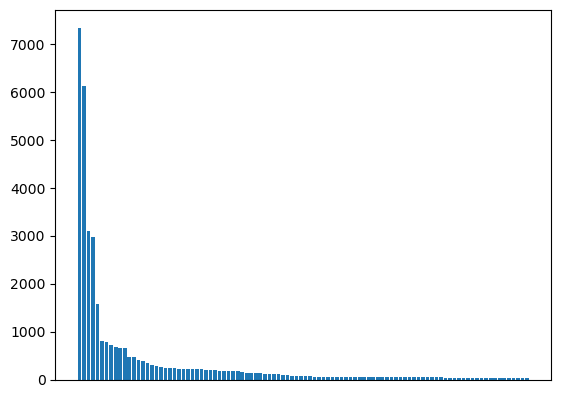

In [162]:
plt.bar(sfreqs.keys(),sfreqs.values())
ax = plt.gca()
ax.get_xaxis().set_visible(False)
plt.show()

202211281515: Status - there are still many names in the file list with patterns like 20200807 or digits like '22', '18', etc. that should be filtered out before use.

things to look for:
    
    20201118
    20210720
    20210210
    july72021
    20210310
    20210708

In [163]:
t1 = find_processed_by_term(proced,'20201118')
len(t1)

0

In [164]:
ids = [p['metadataCollectionId'] for p in t1]
ids

[]

In [165]:
# ok. find file name by id...

def get_entry_by_id(plist,id):
    for p in plist:
        if p['metadataCollectionId'] == id:
            return p
    return None

def get_file_names_by_entry_and_string(plist,id,str_val):
    res =[]
    ent = get_entry_by_id(plist,id)
    if ent is None:
        return None
    for fname  in ent['files']:
        if fname.find(str_val) > 0:
            res.append(str_val)
    return res
    
    

In [166]:
matches =  get_file_names_by_entry_and_string(proced,704,'20201118')

In [167]:
e704=get_entry_by_id(proced,704)

In [168]:
files = [fname for fname in e704['files'] if fname.startswith('syndromic') >0 ]

In [169]:
files

['syndromic-surveillance-gating-criteria_EXPORT_hospital_surge_capacity_covid-19-maine_2020-11-18.csv',
 'syndromic-surveillance-gating-criteria_EXPORT_cases_by_county_covid-19-v2_2020-11-18.csv']

In [170]:
e704['processed'][29:30]

[(['syndromic',
   'surveillance',
   'gating',
   'criteria',
   'export',
   'hospital',
   'surge',
   'capacity',
   'covid',
   '19',
   'maine'],
  'csv')]

In [171]:
(samp1,samp2) = files

* those with just 2 digit numbers?  -05, 06, 07
* race03
* highest50
* t07

In [172]:
t1 =  find_processed_by_term(proced,'19947')
len(t1)

1

In [173]:
t1[0]['metadataCollectionId']

697

In [174]:
t1[0].keys()

dict_keys(['metadataCollectionId', 'titleEnglish', 'files', 'processed'])

In [175]:
t1[0]['titleEnglish']

'Archived Data from Delaware Health and Social Services: "Coronavirus (COVID-19) Data Dashboard - Zipcode Level"'

In [176]:
files = [fname for fname in t1[0]['files'] if fname.__contains__('19947')]

In [177]:
len(files)

2216

In [178]:
files[:10]

['zip-code-19947-outcomes_2020-10-19_162302.csv',
 'zip-code-19947-outcomes_2020-12-05_122304.csv',
 'zip-code-19947-cases_2021-10-30_162304.csv',
 'zip-code-19947-overview_2021-08-28_162303.csv',
 'zip-code-19947-testing_2021-04-09_162304.csv',
 'zip-code-19947-deaths_2021-02-01_122303.csv',
 'zip-code-19947-overview_2021-07-31_162303.csv',
 'zip-code-19947-cases_2020-12-01_122303.csv',
 'zip-code-19947-overview_2020-09-17_162304.csv',
 'zip-code-19947-testing_2021-03-30_162317.csv']

In [179]:
t1 =  find_processed_by_term(proced,'48')
len(t1)

1

In [180]:
files = [fname for fname in t1[0]['files'] if fname.__contains__('48')]
len(files)

7307

In [181]:
files[:10]

['Sheet_48_Payette_2022-06-27_212307.csv',
 'Sheet 48_Fremont_2021-11-15_212759.csv',
 'Sheet_48_Shoshone_2022-02-22_212535.csv',
 'Sheet_48_Bannock_2022-06-06_212307.csv',
 'Sheet 48_Boundary_2021-12-02_212910.csv',
 'Sheet_48_Teton_2022-03-23_212308.csv',
 'Sheet_48_Benewah_2022-05-06_212304.csv',
 'Sheet_48_Idaho_2022-07-13_212305.csv',
 'Sheet_48_Adams_2022-03-30_212307.csv',
 'Sheet_48_Latah_2022-07-20_212307.csv']

In [182]:
t1[0]['titleEnglish']

'Archived Data from Idaho Department of Health and Welfare: "Idaho COVID-19 Dashbaord - Cases by County"'

In [183]:
patterns = precompile_patterns(patlist)
get_base_match(patterns,files[0])

('Payette', 'csv')

In [184]:
get_tokens(patterns,files[1])

(['fremont'], 'csv')

In [185]:
t1 =  find_processed_by_term(proced,'t12')
len(t1)

2

In [188]:
d7s= find_tokens_by_term(proced,'d7')
d7s

{836: [(['tableau',
    'temp',
    'temp',
    '0crbell165o69810qb23000ksfyl',
    '',
    'a561',
    'e12',
    'f30',
    'd144',
    'd7',
    'bae479139647f319',
    ''],
   'csv'),
  (['new',
    'dashboard',
    'extract',
    'new',
    'dashboard',
    'data',
    '',
    'a561',
    'e12',
    'f30',
    'd144',
    'd7',
    'bae479139647f319',
    ''],
   'csv'),
  (['tableau',
    'temp',
    'temp',
    '0zc5ris00zoail189kj1g1dby17z',
    '',
    'a561',
    'e12',
    'f30',
    'd144',
    'd7',
    'bae479139647f319',
    ''],
   'csv'),
  (['tableau',
    'temp',
    'temp',
    '0o8mdh91840tc515x9g910is6eam',
    '',
    'a561',
    'e12',
    'f30',
    'd144',
    'd7',
    'bae479139647f319',
    ''],
   'csv'),
  (['tableau',
    'temp',
    'temp',
    '0y76x9y1mm0ebe17r5huj10lvlsf',
    '',
    'a561',
    'e12',
    'f30',
    'd144',
    'd7',
    'bae479139647f319',
    ''],
   'csv'),
  (['tableau',
    'temp',
    'temp',
    '087e4bu1m04dtn17wfyym1cy4inn

In [ ]:
d7sinit = find_initial_by_substring(proced,'d7')
d7sinit.keys()

In [ ]:
d7sinit[762]

In [ ]:
edge_case = find_initial_by_substring(proced,'0o8mdh91840tc515')
edge_case

so some of these are getting butchered.

In [ ]:
samp = edge_case[836][0]
get_base_match(patterns, edge_case)

In [ ]:
(base_name,ext)=get_base_match(patterns,samp)
base_name_words = re.split(r'\s|_|-',base_name)

In [ ]:
base_name_words

In [ ]:
base_words_no_camel = [camel_case_split(bnw) for bnw in base_name_words]

In [ ]:
base_words_no_camel

ok. so, these strings break camel case. consider not camel case-splitting if start with 'TableauTemp'

----
# Summary of patterns
*  "zip-code-19947-outcomes_2020-10-19_162302.csv" - we will keep the zip code ("19947") as a semantically-meaningful component
* Idaho has "sheet_48" patterns - Sheet_48_Teton_2022-03-23_212308.csv  - filter those out.



---- 
# NMF Clustering

* https://predictivehacks.com/topic-modelling-with-nmf-in-python/
* https://towardsdatascience.com/nmf-a-visual-explainer-and-python-implementation-7ecdd73491f8

TOBEDONE